# Interest-rate sensitivities via zero spread

In this notebook, I'll show a couple of different ways to calculate the sensitivity of an instrument price to changes in the interest-rate curve.

In [1]:
from QuantLib import *
today = Date(8, March, 2016)
Settings.instance().evaluationDate = today

In [2]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter
import numpy as np
import utils
from utils import format_rate

def plot_curves(*curves):
    fig, ax = utils.plot()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda r,pos: format_rate(r)))
    ax.set_xlim(0,15)
    ax.set_xticks([0,5,10,15])
    times = np.linspace(0.0, 15.0, 400)
    for curve, style in curves:
        rates = [ curve.zeroRate(t, Continuous).rate() for t in times ]
        ax.plot(times, rates, style)
def plot_curve(curve):
    plot_curves((curve,'-'))

#### Setup

Let's say we have an interest-rate curve, no matter how it was calculated. As an example, I'll use a curve bootstrapped over the 6-months deposit, a strip of 6-months FRAs and a number of swaps against the 6-months Euribor. All the market inputs are stored in quotes so that their values can be changed.

In [3]:
quotes = [ SimpleQuote(0.312/100) ]
helpers = [ DepositRateHelper(QuoteHandle(quotes[0]),
                              Period(6,Months), 3,
                              TARGET(), Following, False, Actual360()) ]

for rate, months_to_start in [(0.293, 1), (0.272, 2), (0.260, 3),
                              (0.256, 4), (0.252, 5), (0.248, 6),
                              (0.254, 7), (0.261, 8), (0.267, 9),
                              (0.279, 10), (0.291, 11), (0.303, 12),
                              (0.318, 13), (0.335, 14), (0.352, 15),
                              (0.371, 16), (0.389, 17), (0.409, 18)]:
    quotes.append(SimpleQuote(rate/100))
    helpers.append(FraRateHelper(QuoteHandle(quotes[-1]),
                                 months_to_start, Euribor6M()))

for rate, tenor in [(0.424, 3), (0.576, 4), (0.762, 5), (0.954, 6),
                    (1.135, 7), (1.303, 8), (1.452, 9), (1.584, 10),
                    (1.809, 12), (2.037, 15), (2.187, 20), (2.234, 25),
                    (2.256, 30), (2.295, 35), (2.348, 40), (2.421, 50),
                    (2.463, 60)]:
    quotes.append(SimpleQuote(rate/100))
    helpers.append(SwapRateHelper(QuoteHandle(quotes[-1]),
                                  Period(tenor, Years), TARGET(),
                                  Annual, Unadjusted, Thirty360(Thirty360.BondBasis),
                                  Euribor6M()))

rate_curve = PiecewiseLogCubicDiscount(2, TARGET(), helpers, Actual365Fixed())
curve_handle = RelinkableYieldTermStructureHandle(rate_curve)

Here's the curve, plotted over 15 years.

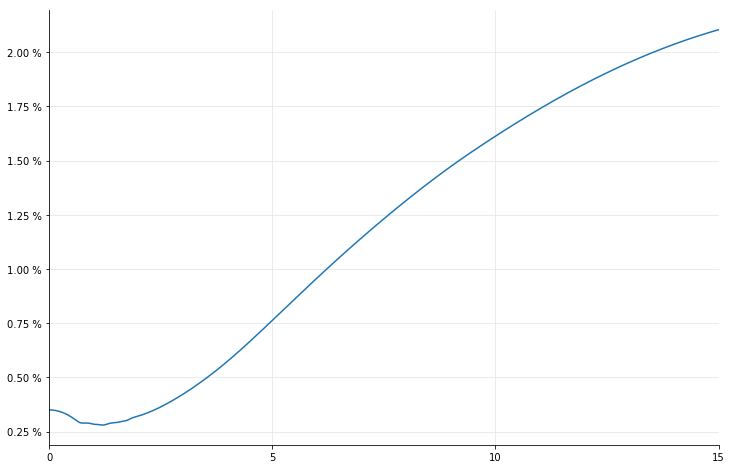

In [4]:
plot_curve(rate_curve)

For illustration purposes, I'll be using the curve to price an interest-rate swap.  Let's create a 12-years swap starting in one month, with an annual schedule for the fixed leg and a semiannual schedule for the floating leg.  We'll use the curve above to forecast the floating-rate fixings, so we pass it to the `Euribor6M` instance that, in turn, we pass to the swap constructor.

In [5]:
fixed_schedule = Schedule(Date(8, April, 2016), Date(8, April, 2028),
                          Period(1, Years), TARGET(), Following, Following,
                          DateGeneration.Forward, False)
floating_schedule = Schedule(Date(8, April, 2016), Date(8, April, 2028),
                             Period(6, Months), TARGET(), Following, Following,
                             DateGeneration.Forward, False)
index = Euribor6M(curve_handle)
swap = VanillaSwap(VanillaSwap.Payer, 10000.0,
                   fixed_schedule, 0.02, Thirty360(),
                   floating_schedule, index, 0.0, Actual360())

Of course, we should use a different curve for discounting.  But let me just skip that part for brevity, and simply pass the same curve to the engine used by the swap.  The points I'm going to make won't suffer for this.

Once we've done this, we can finally get the value of the swap.

In [6]:
swap.setPricingEngine(DiscountingSwapEngine(curve_handle))
P0 = swap.NPV()
print(P0)

-189.83267948709272


Now, let's say that this was you pricing a deal. And let's also say that you're interested (as you should) in how the swap price reacts to changes in the underlying rates.

#### Interest-rate sensitivities

If you're interested in the sensitivities of the price to the input rates, you can have them: shift any input rate by setting a perturbed value to the corresponding quote and recalculate the NPV.
For instance, you can bump the 6-months deposit rate by one basis point and get the new price as follows:

In [7]:
bp = 1.0e-4
ref = quotes[0].value()
quotes[0].setValue(ref+1*bp)
print(swap.NPV())
quotes[0].setValue(ref)

-190.1069970119836


(Also, don't forget to set the value back to the actual quoted rate when you're done).

This can be done for a single rate, as above, or for any number of rates; all of them, for instance...

In [8]:
for q in quotes:
    q.setValue(q.value()+1*bp)
print(swap.NPV())
for q in quotes:
    q.setValue(q.value()-1*bp)

-178.68820577843826


...so the above gives you the swap price when all the input rates move 1 basis point upwards; the difference between the new price and the old one will give you the DV01 of the swap. (Note that, depending on how you define it, you might want to shift either the forecast curve, the discount curve, or both.)

Different combinations of changes can also give you different stress scenarios; for instance, ones in which the curve tilts in some direction, or ones in which you only move the short end or the long end of the curve.  In doing so, though, you're constrained to use the nodes of the original curve. For instance, in the curve above there are no nodes between 20 and 25 years, thus there are no levers to pull in that interval.

As an alternative, you can take an approach in which you modify the curve as a whole independently of the underlying rates. For instance, to shift all the zero rates upwards, you can keep the original curve as it is and add one basis point to all its zero rates by means of the `ZeroSpreadedTermStructure` class.  To use it for pricing our swap, we'll store the original curve in a separate handle, add the spread, and link the new curve to the handle we're using for forecasting.  As usual, the swap price will react accordingly.

In [9]:
base_curve = YieldTermStructureHandle(rate_curve)
spread = SimpleQuote(1*bp)

curve_handle.linkTo(ZeroSpreadedTermStructure(base_curve, QuoteHandle(spread)))
print(swap.NPV())

-178.8676404436867


As we could expect, the result is close to what we got by shifting all the input rates (the difference is just one or two digits in the first decimal place) but not quite the same: modifying, say, an input swap rate doesn't have the same effect as applying the same change to the zero rates directly.  As usual, I'll trust you to know what you're doing in either case.

To get a more visual idea of what we're doing, we can also increase the spread and plot the resulting curve on top of the original one:

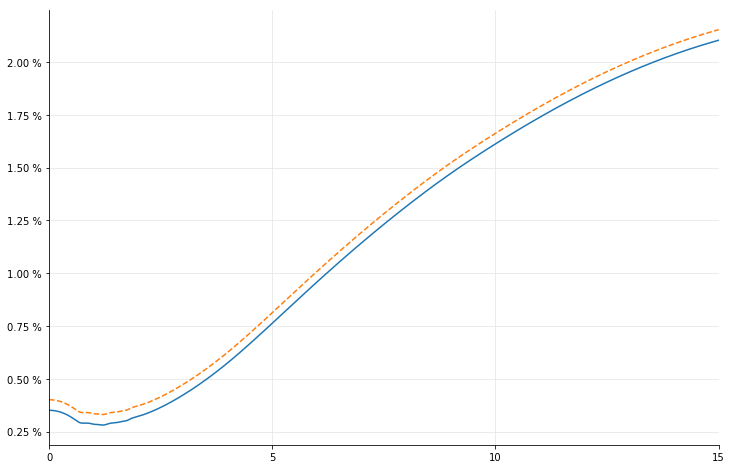

In [10]:
spread.setValue(5*bp)
plot_curves((rate_curve,'-'), (curve_handle,'--'))

Another class, `SpreadedLinearZeroInterpolatedTermStructure` (for whose name I apologize on behalf of the library developers: I don't know what came over us) allows one to apply a spread which is interpolated linearly between a set of nodes, which of course are independent of the nodes of the underlying curve.

For instance, we can create a scenario in which we tilt the curve by taking equally spaced dates each year between now and 20 years, and define the corresponding spreads as negative in the short end, increasing until they reach zero at the 7-years mark, and more and more positive in the long end. Again, we can plot the resulting curve for comparison with the original one...

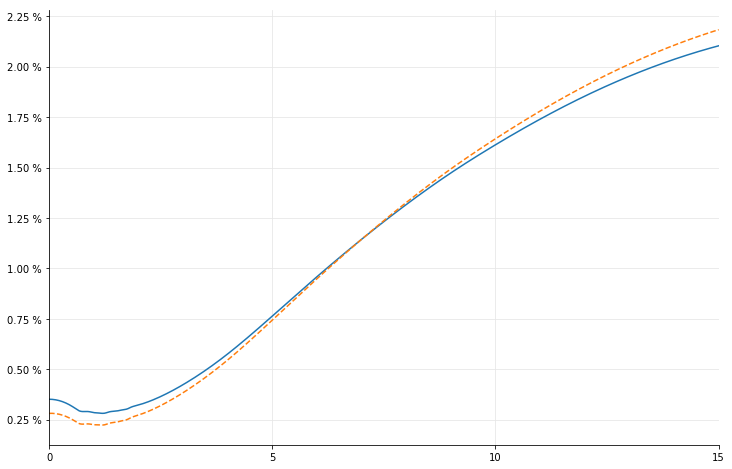

In [11]:
spot = rate_curve.referenceDate()
dates = [ spot + Period(n,Years) for n in range(21)]
spreads = [ QuoteHandle(SimpleQuote((n-7)*bp))  for n in range(21) ]

curve_handle.linkTo(
    SpreadedLinearZeroInterpolatedTermStructure(base_curve, spreads, dates))
plot_curves((rate_curve,'-'), (curve_handle,'--'))

...and again, we can ask the swap for its price under this scenario.

In [12]:
print(swap.NPV())

-138.69485276964178


When using this technique, going back to the actual market quotes simply means linking the curve handle to the original curve:

In [13]:
curve_handle.linkTo(rate_curve)
print(swap.NPV())

-189.83267949204492


If you want more control of the shift (as asked, for instance, by user6142489 [on _Stack Overflow_](https://stackoverflow.com/questions/46279785/quantlib-building-key-rate-risks) who wanted to calculate key-rate risks) you might have to increase the number of nodes. If your nodes are one year apart as above, and if you modify, e.g., the node at 7 years, the interpolation scheme will cause the whole range between 6 and 8 years to change, and all coupons paid in that period to be affected.  The more nodes you have and the closer they are together, the more localized any change will be.